## Project 4: Face recognition ##



As usual, we will mount our Google Driver first and change the current folder to be the one you are working with.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
os.chdir('/content/drive/MyDrive/Deep learning/homework11/face verification')

### 1. Install pacakges ###
Google Colab has installed most of the frequently used packages. For the packages that's not installed, we can use `!pip install ...` to do it.

This project will use the model called 'keras-vggface' that has been trained and shared through GitHub.com. The VGGFace is a face recoginition NN model trained by Visual Geometry Group (VGG) at the University of Oxford. The model was trained using 3.31 million images of 8631 subjects. We will test how this model behaves in different group of people.



Because the 'keras-VGGFace' is only tested on TensorFlow version 1.14, we will need to downgrade both the TensorFlow and the H5PY to accommadate the package. After running the cell below, please restart the runtime (ctrl+M) to make the installed version effective.

In [3]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [4]:
import tensorflow as tf
import h5py
print('H5PY version:', h5py.__version__)

#print(keras.__version__)
print('TensorFlow version:', tf.__version__)

H5PY version: 2.10.0
TensorFlow version: 1.15.2


In [5]:
!pip uninstall h5py
!pip install h5py==2.10.0

Found existing installation: h5py 3.1.0
Uninstalling h5py-3.1.0:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/h5py-3.1.0.dist-info/*
    /usr/local/lib/python3.7/dist-packages/h5py.libs/libaec-9c9e97eb.so.0.0.10
    /usr/local/lib/python3.7/dist-packages/h5py.libs/libhdf5-00e8fae8.so.200.0.0
    /usr/local/lib/python3.7/dist-packages/h5py.libs/libhdf5_hl-383c339f.so.200.0.0
    /usr/local/lib/python3.7/dist-packages/h5py.libs/libsz-e7aa62f5.so.2.0.1
    /usr/local/lib/python3.7/dist-packages/h5py.libs/libz-eb09ad1d.so.1.2.3
    /usr/local/lib/python3.7/dist-packages/h5py/*
Proceed (y/n)? y
  Successfully uninstalled h5py-3.1.0
     |████████████████████████████████| 2.9 MB 9.9 MB/s 


In [5]:
!pip install git+https://github.com/rcmalli/keras-vggface.git
!pip install keras_applications
!pip install keras_preprocessing
!pip install mtcnn

  Cloning https://github.com/rcmalli/keras-vggface.git to /tmp/pip-req-build-doxl674g
  Running command git clone -q https://github.com/rcmalli/keras-vggface.git /tmp/pip-req-build-doxl674g
  Created wheel for keras-vggface: filename=keras_vggface-0.6-py3-none-any.whl size=8325 sha256=1485a1b3ff3a50b945fda7f9da866d660c58c5ad36bda00a8254cc9c42b88ce8
  Stored in directory: /tmp/pip-ephem-wheel-cache-tprhqcp7/wheels/08/df/86/0225d44647ab2256dbf1e006823288fe9cc86367a056e6ea2c
Successfully built keras-vggface
     |████████████████████████████████| 2.3 MB 6.9 MB/s 


We will import the packages here. Please make sure that your package versions are as follows.

H5PY version: 2.10.0

TensorFlow version: 1.x

keras_VGGFace version: 0.6

MTCNN version: 0.1.0

In [6]:
import keras
import numpy as np


# check version of keras_vggface
import keras_vggface
# print version
print('keras_VGGFace version:', keras_vggface.__version__)

# confirm mtcnn was installed correctly
import mtcnn
# print version
print('MTCNN version:', mtcnn.__version__)

from matplotlib import pyplot
import matplotlib.image as mpimg
from PIL import Image
from numpy import asarray
from mtcnn.mtcnn import MTCNN
from scipy.spatial.distance import cosine
from keras_vggface.vggface import VGGFace
from keras_vggface.utils import preprocess_input
from keras_vggface.utils import decode_predictions

Using TensorFlow backend.


keras_VGGFace version: 0.6
MTCNN version: 0.1.0


### 2. Detect faces ###

Before we can perform face recognition, we need to detect faces.

Face detection is the process of automatically locating faces in a photograph and localizing them by drawing a bounding box around their extent.

In this tutorial, we will also use the Multi-Task Cascaded Convolutional Neural Network, or MTCNN, for face detection, e.g. finding and extracting faces from photos. This is a state-of-the-art deep learning model for face detection, described in the 2016 paper titled “Joint Face Detection and Alignment Using Multitask Cascaded Convolutional Networks.”

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


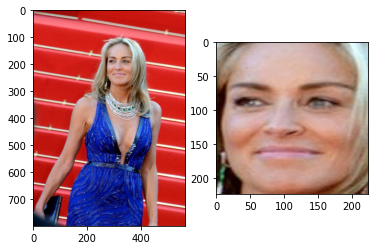

In [7]:
# extract a single face from a given photograph
def extract_face(filename, required_size=(224, 224)):
	# load image from file
	pixels = pyplot.imread(filename)
	# create the detector, using default weights
	detector = MTCNN()
	# detect faces in the image
	results = detector.detect_faces(pixels)
	# extract the bounding box from the first face
	x1, y1, width, height = results[0]['box']
	x2, y2 = x1 + width, y1 + height
	# extract the face
	face = pixels[y1:y2, x1:x2]
	# resize pixels to the model size
	image = Image.fromarray(face)
	image = image.resize(required_size)
	face_array = asarray(image)
	return face_array

## start your code here
image_path='images/sharon_stone1.jpg' # you can change the path to the path of your own image
## end your code here

orig_img = mpimg.imread(image_path)

# load the photo and extract the face
pixels = extract_face(image_path)

fig = pyplot.figure()
# plot the original image
ax = fig.add_subplot(1, 2, 1)
imgplot = pyplot.imshow(orig_img)
# plot the extracted face
ax = fig.add_subplot(1, 2, 2)
imgplot = pyplot.imshow(pixels)

# show the plot
pyplot.show()


### 3. Face identification ###
A VGGFace model can be created using the VGGFace() constructor and specifying the type of model to create via the 'model' argument

`model = VGGFace(model='...')`

The keras-vggface library provides three pre-trained VGGModels, a VGGFace1 model via model=’vgg16′ (the default), and two VGGFace2 models 'resnet50' and 'senet50'.

The example below creates a 'resnet50' VGGFace2 model.

The first time that a model is created, the library will download the model weights and save them in the ./keras/models/vggface/ directory in your home directory. The size of the weights for the resnet50 model is about 158 megabytes, so the download may take a few minutes depending on the speed of your internet connection.

If printing out the NN structure, we can observe the apparant 'resnet' structure. 

**Exercise**: Can you find the flatten layer and the dense layer(s) on top of the conv layers? For every image, how many elements are there in the flatten layer? How many elements are there in the output layer?

**The output of the flatten layer is the features extracted from the face.**

In [8]:
# create a vggface model
model = VGGFace(model='resnet50')
tf.keras.utils.plot_model(model, show_shapes=True)

Output hidden; open in https://colab.research.google.com to view.

Before we can make a prediction with a face, the pixel values must be scaled in the same way that data was prepared when the VGGFace model was trained. Specifically, the pixel values must be centered on each channel using the mean from the training dataset.

In [9]:
# convert one face into samples
pixels = pixels.astype('float32')
samples = np.expand_dims(pixels, axis=0)
# prepare the face for the model, e.g. center pixels
samples = preprocess_input(samples, version=2)

# perform prediction
yhat = model.predict(samples)
# convert prediction into names
results = decode_predictions(yhat)
# display most likely results
for result in results[0]:
	print('%s: %.3f%%' % (result[0], result[1]*100))


1351680/1346516 [==============================] - 0s 0us/step
b' Sharon_Stone': 99.574%
b' Noelle_Reno': 0.080%
b' Anita_Lipnicka': 0.027%
b' Elisabeth_R\xc3\xb6hm': 0.027%
b' Emma_Atkins': 0.019%


Do you want to find out which super star(s) you look like the most? Upload your images to your Google Drive, and change the image_path to the path of your own image in Section 2. The place between 'start your code here' and 'end your code here'. 

### 4. Face verification ###
Have enough fun? Now, let us see whether the VGGFace model can tell I am who I am. 

First of all, we need to extract the features from the face. Compared with the model we used before, we would like the output from the flatten layer. Therefore, this time when loading the model, we will ignore the top dense layer. 

**Exercise**: please compare 'model' with 'model_notop'. Do you see any differences?

In [10]:
# create a vggface model without top levels
model_notop = VGGFace(model='resnet50', include_top=False, input_shape=(224, 224, 3), pooling='avg')
tf.keras.utils.plot_model(model_notop, show_shapes=True)

Output hidden; open in https://colab.research.google.com to view.

A VGGFace2 model calculates a face embedding, a vector that represents the features extracted from the face. This can then be compared with the vectors generated for other faces. For example, another vector that is close (by some measure) may be the same person, whereas another vector that is far (by some measure) may be a different person.

Typical measures such as Euclidean distance and Cosine distance are calculated between two embeddings and faces are said to match or verify if the distance is below a predefined threshold, often tuned for a specific dataset or application.

The face embedding can be calculated by calling `model_name.predict(pre_processed_image)`. We integrate image processing and face embedding in one function 'get_embeddings(filenames, model)'. In this function, the name of the NN model is 'model'. 

**Exercise**: finish the function and call the function with correct NN model.

In [11]:
# extract faces and calculate face embeddings for a list of photo files
def get_embeddings(filenames,model):
	# extract faces
	faces = [extract_face(f) for f in filenames]
	# convert into an array of samples
	samples = asarray(faces, 'float32')
	# prepare the face for the model, e.g. center pixels
	samples = preprocess_input(samples, version=2)
	# perform prediction

  ## start your code here
	yhat = model.predict(samples)
  ## end your code here

	return yhat

# start your code here
embedding_test=get_embeddings(['images/sharon_stone1.jpg'],model) # Please replace None to the model_name that you will use to extract face embedding.
# end your code here
print(embedding_test.shape)

(1, 8631)


If two embeddings extracted from two faces are similar to each other, we say the two faces are for the same person. Here, we use cosine similarity. 

![](https://drive.google.com/uc?export=view&id=1MM4nrvWmmP7QK8U87uf3D9hfMsyaD2zG)



In [13]:
# determine if a candidate face is a match for a known face
def is_match(known_embedding, candidate_embedding, thresh=0.5):
	# calculate distance between embeddings
	score = cosine(known_embedding, candidate_embedding)
	if score <= thresh:
		print('>face is a Match (%.3f <= %.3f)' % (score, thresh))
	else:
		print('>face is NOT a Match (%.3f > %.3f)' % (score, thresh))

# Get the face embedding of sharon
sharon_id=get_embeddings(['images/sharon_stone1.jpg'],model_notop)
# Get the face embedding of another image
# start your code here
sharon_cand=get_embeddings(['images/sharon_stone2.jpg'], model_notop)
is_match(sharon_id,sharon_cand) # call the is_match function to see whether the image you choose is Sharon Stone. 
# end your code here

>face is a Match (0.463 <= 0.500)


We can do this in bulk. Get the embeddings of a bunch of pictures and to see whether the first image matches the persons in the other images.

**Exercise**: you can try your own pictures to test how well the VGGFace model is. 

I find the VGGFace model is not quite effective on asian faces. Do you have any idea to improve it?

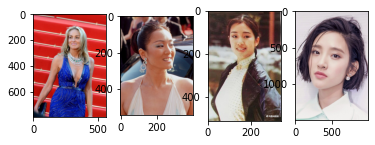

image 1 vs image 2:
>face is NOT a Match (0.639 > 0.500)
image 1 vs image 3:
>face is NOT a Match (0.706 > 0.500)
image 1 vs image 4:
>face is NOT a Match (0.768 > 0.500)


In [15]:
# define filenames, check whether the person in the first image is the same person that appears in the other images.

# start your code here
filenames = ['images/sharon_stone1.jpg', 'images/li_gong2.jpg', 'images/li_gong1.jpg', 'images/yixin_tang.jpg'] # you can download the images to your driver, and then replace 'None' to the image path. Notice: you will need to quote the image path, i.e. '../../../image_name.jpg'
# end your code here

#filenames =['images/sharon_stone1.jpg','images/sharon_stone2.jpg','images/sharon_stone3.jpg','images/li_gong1.jpg']

fig = pyplot.figure()
# plot the original image
ax = fig.add_subplot(1, 4, 1)
imgplot = pyplot.imshow(mpimg.imread(filenames[0]))

ax = fig.add_subplot(1, 4, 2)
imgplot = pyplot.imshow(mpimg.imread(filenames[1]))

ax = fig.add_subplot(1, 4, 3)
imgplot = pyplot.imshow(mpimg.imread(filenames[2]))

ax = fig.add_subplot(1, 4, 4)
imgplot = pyplot.imshow(mpimg.imread(filenames[3]))

# show the plot
pyplot.show()

# get embeddings file filenames
embeddings = get_embeddings(filenames,model_notop)
# define sharon stone
sharon_id = embeddings[0]
# verify known photos of Gong-Li
print('image 1 vs image 2:')
is_match(embeddings[0], embeddings[1])
print('image 1 vs image 3:')
is_match(embeddings[0], embeddings[2])
# verify known photos of other people
print('image 1 vs image 4:')
is_match(embeddings[0], embeddings[3])